>[imports](#scrollTo=HKBQVXGJGdtQ)

>[Loading the data and pre-processing steps](#scrollTo=oZR0TAxg-VPa)

>[Task 1: Colorectal Cancer Classification Using CNNs](#scrollTo=8uYob-Isse53)

>[Task 1 - part a : implementing ResNet-50 architecture and training from the scratch](#scrollTo=eh_IZfxP_7lk)

>>[Model Training](#scrollTo=_9oO8yZX_ni5)

>>[Model Optimization by hyperparameter grid search](#scrollTo=BPa7Zg6l_tq7)

>>[Results for Task 1 - Part a](#scrollTo=gzU9gSrRAHd5)

>>>[Evaluation](#scrollTo=P4YdZpudBDPR)

>>>[Visualization with T-SNE](#scrollTo=qv4QJSI4BGdv)

>[Task 1 - part b :using a pre-trained network for  Clorectal Cancer Classification](#scrollTo=o48x2wqbAPMz)

>>[loading the Pre-trained Network](#scrollTo=frJPrbojsiEO)

>>[Fine-tuning for Colorectal Cancer Classification](#scrollTo=COk1y7WfBjtE)

>>[Results for Task 1 - part b](#scrollTo=q1EliJWnHjgo)

>>>[Evaluation](#scrollTo=zdp-oK9tHmlQ)

>>>[T-SNE Visualization](#scrollTo=1AJEvh4hHvPO)

>[Task 2](#scrollTo=pm1iOvJxKnkQ)

>>[using the CNN encoder trained in task 1](#scrollTo=cTthWn4-L7Am)

>>>[extracting features](#scrollTo=Ozx0fK9nxjx4)

>>>[t-SNE visualization](#scrollTo=2C0iKR6CMsyx)

>>[using pre-trained VGG16](#scrollTo=-ndQiJpPrJqm)

>>>[extracting features](#scrollTo=KIm9QphnMWVO)

>>>[t-SNE visualization](#scrollTo=JFk-td8EM1kC)

>>>[training ML models to classify the extracted features](#scrollTo=VgcnG4kGM1kC)

>>>>[k-nearest neighbors](#scrollTo=gUzxiZtlJoFS)

>>>>[Random Forrest](#scrollTo=-11mr-0zJs_z)



# imports


In [3]:
import torch
from google.colab import drive
from torchvision import transforms
from torchvision.datasets import ImageFolder
import pickle
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset

import time
import copy
import seaborn as sns
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from sklearn.model_selection import ParameterGrid
from torchvision import datasets, transforms
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Useful Functions


In [4]:
def evaluate_model_on_test_set(model_path, dataloader):
    # Load the saved model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load(model_path)
    model = model.to(device)
    model.eval()
    all_labels = []
    all_predictions = []

    # Don't calculate gradients
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            # Move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and true labels
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    return all_predictions, all_labels


In [6]:
def visualize_features(model, test_loader, device,title):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = model(inputs).cpu().numpy()
            all_features.append(features)
            all_labels.append(labels.cpu().numpy())

    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(all_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=all_labels, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()



# **Loading the data and pre-processing steps**

In [5]:

# Mount your Google Drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Comp6321 project dataset/'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

datasets = {}

dataset_names = ['Colorectal Cancer', 'Prostate Cancer', 'Animal Faces']

for dataset_name in dataset_names:
    dataset_path = base_path + dataset_name
    dataset = ImageFolder(root=dataset_path, transform=transform)
    datasets[dataset_name] = dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
colorectral_dataset_path = "/content/drive/MyDrive/Comp6321 project dataset/Colorectal Cancer"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Task 1: Colorectal Cancer Classification Using CNNs**


# Task 1 - part a : implementing ResNet-50 architecture and training from the scratch

**Create Torchvision Imagefolder dataset**

In [6]:
colorectral_dataset =datasets['Colorectal Cancer']

**Train, test, validation splitting**

In [7]:
# 70% Training, 15% Validation, 15% Testing
train_size = int(0.7 * len(colorectral_dataset))
val_size = int(0.15 * len(colorectral_dataset))
test_size = len(colorectral_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(colorectral_dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)


# Now you can create your dataloaders dictionary
colorectral_dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

# And your dataset_sizes dictionary
colorectral_dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

**Defining the Colorectral Cancer Detection Class**

In [8]:
class ImageClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def create_model(self):
        # Create a ResNet model without pretraining
        model = models.resnet50(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, self.num_classes)
        return model.to(self.device)

    def get_loss(self):
        # Define the criterion
        return nn.CrossEntropyLoss()

    def get_optimizer(self, model):
        # Observe that all parameters are being optimized
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    def get_scheduler(self, optimizer):
        # Decay LR by a factor of 0.1 every 7 epochs
        return lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    def train_model(self, model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

         # to keep track of loss and accuracy for plotting
        train_loss, val_loss = [], []
        train_acc, val_acc = [], []

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_acc = epoch_acc.item()

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # record loss and accuracy
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, train_loss, val_loss, train_acc, val_acc, preds, labels.data

    def run(self, dataloaders, dataset_sizes):
        best_model = self.train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes)
        return best_model


**Training a ResNet-50 from scratch - Three Classes**

In [ ]:
num_classes = 3
classifier = ImageClassifier(num_classes=num_classes)
model = classifier.create_model()
criterion = classifier.get_loss()
optimizer = classifier.get_optimizer(model)
scheduler = classifier.get_scheduler(optimizer)
colorectral_best_model, train_loss, val_loss, train_acc, val_acc, prediction, labels = classifier.run(colorectral_dataloaders, colorectral_dataset_sizes)

Epoch 1/10
----------


100%|██████████| 263/263 [21:14<00:00,  4.85s/it]


train Loss: 1.1211 Acc: 0.5257


100%|██████████| 57/57 [04:23<00:00,  4.62s/it]


val Loss: 0.6767 Acc: 0.6478

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.12it/s]


train Loss: 0.6432 Acc: 0.7490


100%|██████████| 57/57 [00:03<00:00, 16.69it/s]


val Loss: 1.3922 Acc: 0.6200

Epoch 3/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.35it/s]


train Loss: 0.5050 Acc: 0.8112


100%|██████████| 57/57 [00:03<00:00, 16.45it/s]


val Loss: 0.3451 Acc: 0.8633

Epoch 4/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.35it/s]


train Loss: 0.4201 Acc: 0.8352


100%|██████████| 57/57 [00:03<00:00, 16.30it/s]


val Loss: 0.3717 Acc: 0.8567

Epoch 5/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.38it/s]


train Loss: 0.4186 Acc: 0.8440


100%|██████████| 57/57 [00:03<00:00, 16.22it/s]


val Loss: 0.3984 Acc: 0.8300

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.40it/s]


train Loss: 0.3243 Acc: 0.8786


100%|██████████| 57/57 [00:03<00:00, 16.29it/s]


val Loss: 0.2400 Acc: 0.9211

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.37it/s]


train Loss: 0.3169 Acc: 0.8843


100%|██████████| 57/57 [00:03<00:00, 16.45it/s]


val Loss: 0.9912 Acc: 0.6756

Epoch 8/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.44it/s]


train Loss: 0.2076 Acc: 0.9269


100%|██████████| 57/57 [00:03<00:00, 15.93it/s]


val Loss: 0.1779 Acc: 0.9378

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.26it/s]


train Loss: 0.1907 Acc: 0.9307


100%|██████████| 57/57 [00:03<00:00, 16.02it/s]


val Loss: 0.1907 Acc: 0.9278

Epoch 10/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.33it/s]


train Loss: 0.1839 Acc: 0.9314


100%|██████████| 57/57 [00:03<00:00, 16.05it/s]

val Loss: 0.1606 Acc: 0.9444

Training complete in 29m 59s
Best val Acc: 0.944444


**Plotting Loss and Accuracy**

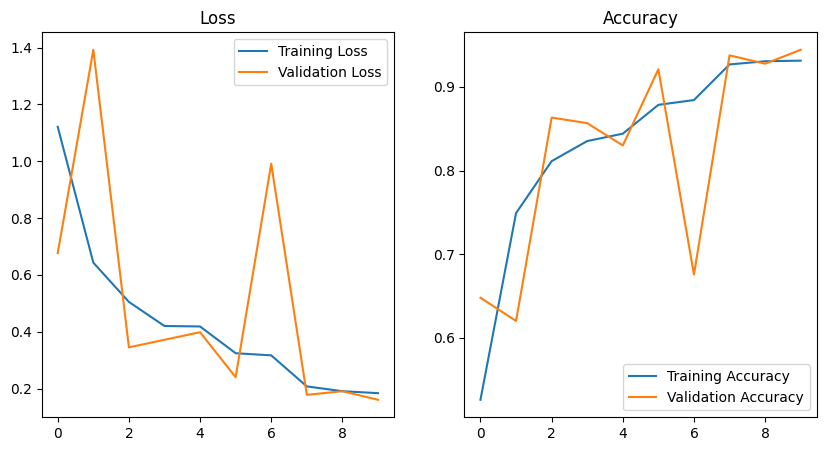

In [ ]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.array(train_acc), label='Training Accuracy')
plt.plot(np.array(val_acc), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

**Save the best model**

In [ ]:
best_model_path = colorectral_dataset_path + '/weights/' + 'colorectral_model_weights.pth'
torch.save(colorectral_best_model, best_model_path)

**Loading model and evaluate using test set**

100%|██████████| 57/57 [00:03<00:00, 16.29it/s]


F1 Score: 0.9578990058233257
Precision: 0.9599534414929893
Recall: 0.9577777777777777


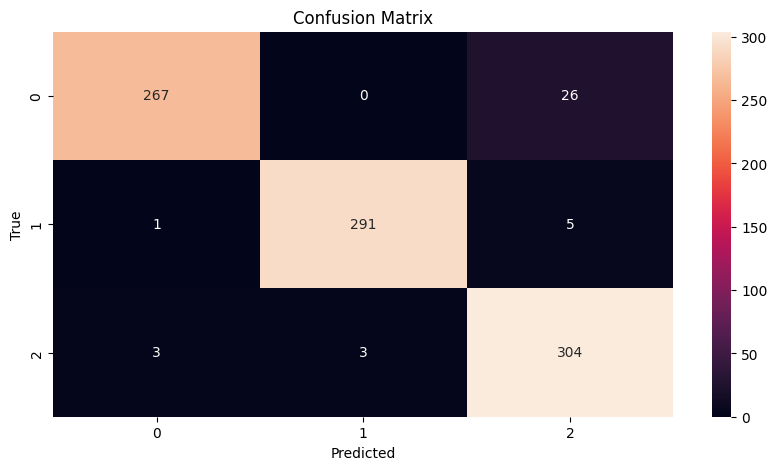

In [ ]:
# Calculate metrics
predictions, labels = evaluate_model_on_test_set(best_model_path, test_dataloader)
y_true = labels
y_pred = predictions


f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Print metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Model Training

## Model Optimization by hyperparameter grid search

**Grid Search on hyperparameters: learning rate, batch size, and loss function.**

In [ ]:
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Define the hyperparameters
param_grid = {
    'lr': [0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'loss_func': ['CrossEntropyLoss', 'NLLLoss'],
    'momentum': [0.9]
}

grid = ParameterGrid(param_grid)

best_acc = 0.0
best_params = None

for params in grid:
    # Create a new ImageClassifier with the current parameters
    classifier = ImageClassifier(num_classes=3)

    # Create new dataloaders with the current batch size
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True)
    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    # Create a new optimizer with the current learning rate and momentum
    model = classifier.create_model()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
    scheduler = classifier.get_scheduler(optimizer)

    # Create a new loss function with the current loss function
    if params['loss_func'] == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif params['loss_func'] == 'NLLLoss':
        criterion = nn.NLLLoss()

    # Train the model
    model, train_loss, train_acc, val_loss, val_acc, __, __ = classifier.train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes)

    print("----------")
    print()
    print('Parameters:', params)
    print('Training Loss:', train_loss[-1])
    print('Training Accuracy:', train_acc[-1])
    print('Validation Loss:', val_loss[-1])
    print('Validation Accuracy:', val_acc[-1])
    print()
    print("----------")

    # Evaluate the model on the validation set
    val_acc = evaluate_model(model, dataloaders['val'])

    # If this model has the best accuracy so far, save it and its parameters
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model_gs = model

print('Best parameters:', best_params)
best_model_gs_path = colorectral_dataset_path + 'colorectral_model_weights_gs.pth'
torch.save(best_model_gs, best_model_gs_path)


Epoch 1/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.47it/s]


train Loss: 5.3974 Acc: 0.4121


100%|██████████| 57/57 [00:03<00:00, 16.49it/s]


val Loss: 1.8261 Acc: 0.4778

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.50it/s]


train Loss: 0.8571 Acc: 0.6036


100%|██████████| 57/57 [00:03<00:00, 17.07it/s]


val Loss: 0.7937 Acc: 0.7200

Epoch 3/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.27it/s]


train Loss: 0.6572 Acc: 0.7107


100%|██████████| 57/57 [00:03<00:00, 15.53it/s]


val Loss: 0.5450 Acc: 0.7922

Epoch 4/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.22it/s]


train Loss: 0.6104 Acc: 0.7433


100%|██████████| 57/57 [00:03<00:00, 16.43it/s]


val Loss: 0.6826 Acc: 0.7522

Epoch 5/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.58it/s]


train Loss: 0.5800 Acc: 0.7574


100%|██████████| 57/57 [00:03<00:00, 16.39it/s]


val Loss: 0.4654 Acc: 0.8078

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.45it/s]


train Loss: 0.5404 Acc: 0.7774


100%|██████████| 57/57 [00:03<00:00, 16.69it/s]


val Loss: 0.5778 Acc: 0.8311

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.50it/s]


train Loss: 0.5217 Acc: 0.7907


100%|██████████| 57/57 [00:03<00:00, 16.61it/s]


val Loss: 0.5023 Acc: 0.7956

Epoch 8/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.55it/s]


train Loss: 0.4375 Acc: 0.8250


100%|██████████| 57/57 [00:03<00:00, 16.48it/s]


val Loss: 0.3932 Acc: 0.8500

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.31it/s]


train Loss: 0.4449 Acc: 0.8200


100%|██████████| 57/57 [00:03<00:00, 16.12it/s]


val Loss: 0.4610 Acc: 0.8556

Epoch 10/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.33it/s]


train Loss: 0.4121 Acc: 0.8350


100%|██████████| 57/57 [00:03<00:00, 16.62it/s]


val Loss: 0.4419 Acc: 0.8600

Training complete in 4m 47s
Best val Acc: 0.860000
----------

Parameters: {'batch_size': 16, 'loss_func': 'CrossEntropyLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: 0.4120646776471819
Training Accuracy: 0.44192175176408555
Validation Loss: 0.835
Validation Accuracy: 0.86

----------
Epoch 1/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.35it/s]


train Loss: 1.3530 Acc: 0.5743


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


val Loss: 0.5820 Acc: 0.7911

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.30it/s]


train Loss: 0.7817 Acc: 0.7333


100%|██████████| 57/57 [00:03<00:00, 16.44it/s]


val Loss: 0.4506 Acc: 0.8400

Epoch 3/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.43it/s]


train Loss: 0.5539 Acc: 0.7838


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


val Loss: 0.5384 Acc: 0.8489

Epoch 4/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.30it/s]


train Loss: 0.4459 Acc: 0.8345


100%|██████████| 57/57 [00:03<00:00, 16.72it/s]


val Loss: 0.6358 Acc: 0.8767

Epoch 5/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.36it/s]


train Loss: 0.4249 Acc: 0.8412


100%|██████████| 57/57 [00:03<00:00, 15.99it/s]


val Loss: 0.5903 Acc: 0.8589

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.30it/s]


train Loss: 0.3360 Acc: 0.8695


100%|██████████| 57/57 [00:03<00:00, 15.61it/s]


val Loss: 1.9058 Acc: 0.8778

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.26it/s]


train Loss: 0.3352 Acc: 0.8712


100%|██████████| 57/57 [00:03<00:00, 15.86it/s]


val Loss: 0.3840 Acc: 0.8967

Epoch 8/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.26it/s]


train Loss: 0.2505 Acc: 0.9081


100%|██████████| 57/57 [00:03<00:00, 16.52it/s]


val Loss: 0.5729 Acc: 0.9067

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.39it/s]


train Loss: 0.2254 Acc: 0.9157


100%|██████████| 57/57 [00:03<00:00, 16.33it/s]


val Loss: 1.2400 Acc: 0.8811

Epoch 10/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.31it/s]


train Loss: 0.2095 Acc: 0.9205


100%|██████████| 57/57 [00:03<00:00, 15.87it/s]


val Loss: 0.3882 Acc: 0.9178

Training complete in 4m 50s
Best val Acc: 0.917778
----------

Parameters: {'batch_size': 16, 'loss_func': 'CrossEntropyLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: 0.20949651366188413
Training Accuracy: 0.38819113307529024
Validation Loss: 0.9204761904761904
Validation Accuracy: 0.9177777777777778

----------
Epoch 1/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.44it/s]


train Loss: 1.0072 Acc: 0.5495


100%|██████████| 57/57 [00:03<00:00, 16.35it/s]


val Loss: 0.8516 Acc: 0.6489

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.33it/s]


train Loss: 0.6796 Acc: 0.7421


100%|██████████| 57/57 [00:03<00:00, 16.26it/s]


val Loss: 0.6333 Acc: 0.7789

Epoch 3/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.33it/s]


train Loss: 0.5038 Acc: 0.7990


100%|██████████| 57/57 [00:03<00:00, 15.95it/s]


val Loss: 0.5185 Acc: 0.7922

Epoch 4/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.39it/s]


train Loss: 0.4596 Acc: 0.8221


100%|██████████| 57/57 [00:03<00:00, 16.11it/s]


val Loss: 0.4499 Acc: 0.8856

Epoch 5/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.31it/s]


train Loss: 0.4075 Acc: 0.8448


100%|██████████| 57/57 [00:03<00:00, 16.19it/s]


val Loss: 0.2977 Acc: 0.9000

Epoch 6/10
----------


100%|██████████| 263/263 [00:26<00:00, 10.02it/s]


train Loss: 0.3461 Acc: 0.8733


100%|██████████| 57/57 [00:03<00:00, 15.37it/s]


val Loss: 0.4860 Acc: 0.8278

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.31it/s]


train Loss: 0.3185 Acc: 0.8690


100%|██████████| 57/57 [00:03<00:00, 16.52it/s]


val Loss: 0.2859 Acc: 0.8944

Epoch 8/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.26it/s]


train Loss: 0.2110 Acc: 0.9221


100%|██████████| 57/57 [00:03<00:00, 16.17it/s]


val Loss: 0.1961 Acc: 0.9278

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.34it/s]


train Loss: 0.2048 Acc: 0.9162


100%|██████████| 57/57 [00:03<00:00, 16.43it/s]


val Loss: 0.1884 Acc: 0.9289

Epoch 10/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.40it/s]


train Loss: 0.1895 Acc: 0.9286


100%|██████████| 57/57 [00:03<00:00, 15.73it/s]


val Loss: 0.1902 Acc: 0.9311

Training complete in 4m 51s
Best val Acc: 0.931111
----------

Parameters: {'batch_size': 16, 'loss_func': 'CrossEntropyLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: 0.18952083616739226
Training Accuracy: 0.1902153756138351
Validation Loss: 0.9285714285714286
Validation Accuracy: 0.9311111111111111

----------
Epoch 1/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.35it/s]


train Loss: nan Acc: 0.3279


100%|██████████| 57/57 [00:03<00:00, 16.20it/s]


val Loss: nan Acc: 0.3311

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.38it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 15.67it/s]


val Loss: nan Acc: 0.3311

Epoch 3/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.28it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.26it/s]


val Loss: nan Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.21it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


val Loss: nan Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.19it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.21it/s]


val Loss: nan Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.42it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.41it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.35it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.75it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.36it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.18it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.21it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 15.65it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.48it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 17.02it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 50s
Best val Acc: 0.331111
----------

Parameters: {'batch_size': 16, 'loss_func': 'NLLLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.49it/s]


train Loss: -7059738795234829.0000 Acc: 0.3829


100%|██████████| 57/57 [00:03<00:00, 16.63it/s]


val Loss: -445112726134586816.0000 Acc: 0.3456

Epoch 2/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.47it/s]


train Loss: nan Acc: 0.3383


100%|██████████| 57/57 [00:03<00:00, 16.23it/s]


val Loss: nan Acc: 0.3311

Epoch 3/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.61it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.73it/s]


val Loss: nan Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.59it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.84it/s]


val Loss: nan Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.56it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.43it/s]


val Loss: nan Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.40it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.29it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.56it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.85it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.56it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.85it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.66it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.92it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.61it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.13it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 44s
Best val Acc: 0.345556
----------

Parameters: {'batch_size': 16, 'loss_func': 'NLLLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.54it/s]


train Loss: -8526.0041 Acc: 0.5083


100%|██████████| 57/57 [00:03<00:00, 16.91it/s]


val Loss: -22781.9738 Acc: 0.1767

Epoch 2/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.64it/s]


train Loss: -1223415.9107 Acc: 0.5912


100%|██████████| 57/57 [00:03<00:00, 16.80it/s]


val Loss: -4128241.8222 Acc: 0.3311

Epoch 3/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.60it/s]


train Loss: -246737170.0324 Acc: 0.5602


100%|██████████| 57/57 [00:03<00:00, 16.18it/s]


val Loss: -60822541707.9467 Acc: 0.3456

Epoch 4/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.55it/s]


train Loss: -58182934357.8210 Acc: 0.4726


100%|██████████| 57/57 [00:03<00:00, 17.70it/s]


val Loss: -339444980048.7822 Acc: 0.3456

Epoch 5/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.58it/s]


train Loss: -14315093590827.3984 Acc: 0.3629


100%|██████████| 57/57 [00:03<00:00, 16.66it/s]


val Loss: -82370931263478.8906 Acc: 0.3456

Epoch 6/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.47it/s]


train Loss: -3566451740242271.0000 Acc: 0.3726


100%|██████████| 57/57 [00:03<00:00, 16.50it/s]


val Loss: -20097768050100652.0000 Acc: 0.3233

Epoch 7/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.40it/s]


train Loss: -891741223106483072.0000 Acc: 0.3343


100%|██████████| 57/57 [00:03<00:00, 16.26it/s]


val Loss: -5097698926015281152.0000 Acc: 0.5722

Epoch 8/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.50it/s]


train Loss: -6885707956906223616.0000 Acc: 0.3505


100%|██████████| 57/57 [00:03<00:00, 16.70it/s]


val Loss: -9273245034001702912.0000 Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 263/263 [00:25<00:00, 10.48it/s]


train Loss: -12556451154507608064.0000 Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.57it/s]


val Loss: -16648967512075438080.0000 Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 263/263 [00:24<00:00, 10.59it/s]


train Loss: -22899056953976434688.0000 Acc: 0.3355


100%|██████████| 57/57 [00:03<00:00, 16.82it/s]


val Loss: -30409189531869876224.0000 Acc: 0.3311

Training complete in 4m 44s
Best val Acc: 0.572222
----------

Parameters: {'batch_size': 16, 'loss_func': 'NLLLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: -2.2899056953976435e+19
Training Accuracy: -3.0409189531869876e+19
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: 4.4524 Acc: 0.4486


100%|██████████| 29/29 [00:03<00:00,  8.66it/s]


val Loss: 1.6094 Acc: 0.5078

Epoch 2/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.50it/s]


train Loss: 0.9763 Acc: 0.5786


100%|██████████| 29/29 [00:03<00:00,  8.56it/s]


val Loss: 0.9959 Acc: 0.7011

Epoch 3/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: 0.7501 Acc: 0.6514


100%|██████████| 29/29 [00:03<00:00,  8.87it/s]


val Loss: 0.7804 Acc: 0.7156

Epoch 4/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.52it/s]


train Loss: 0.6838 Acc: 0.7121


100%|██████████| 29/29 [00:03<00:00,  8.78it/s]


val Loss: 0.7815 Acc: 0.7678

Epoch 5/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


train Loss: 0.6883 Acc: 0.7445


100%|██████████| 29/29 [00:03<00:00,  8.67it/s]


val Loss: 0.6233 Acc: 0.7933

Epoch 6/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.57it/s]


train Loss: 0.5873 Acc: 0.7871


100%|██████████| 29/29 [00:03<00:00,  8.53it/s]


val Loss: 0.6522 Acc: 0.7511

Epoch 7/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: 0.5292 Acc: 0.7986


100%|██████████| 29/29 [00:03<00:00,  8.30it/s]


val Loss: 1.4656 Acc: 0.5511

Epoch 8/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.44it/s]


train Loss: 0.4482 Acc: 0.8317


100%|██████████| 29/29 [00:03<00:00,  8.74it/s]


val Loss: 0.3966 Acc: 0.8522

Epoch 9/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.59it/s]


train Loss: 0.3885 Acc: 0.8467


100%|██████████| 29/29 [00:03<00:00,  8.87it/s]


val Loss: 0.3808 Acc: 0.8511

Epoch 10/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.54it/s]


train Loss: 0.3863 Acc: 0.8495


100%|██████████| 29/29 [00:03<00:00,  8.63it/s]


val Loss: 0.3921 Acc: 0.8544

Training complete in 4m 33s
Best val Acc: 0.854444
----------

Parameters: {'batch_size': 32, 'loss_func': 'CrossEntropyLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: 0.3862656285081591
Training Accuracy: 0.39206275367074545
Validation Loss: 0.8495238095238096
Validation Accuracy: 0.8544444444444445

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.40it/s]


train Loss: 1.1519 Acc: 0.6310


100%|██████████| 29/29 [00:03<00:00,  8.26it/s]


val Loss: 0.7881 Acc: 0.7989

Epoch 2/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.51it/s]


train Loss: 0.6236 Acc: 0.7905


100%|██████████| 29/29 [00:03<00:00,  8.90it/s]


val Loss: 1.2963 Acc: 0.8311

Epoch 3/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: 0.5670 Acc: 0.8302


100%|██████████| 29/29 [00:03<00:00,  8.88it/s]


val Loss: 0.4141 Acc: 0.8500

Epoch 4/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


train Loss: 0.3806 Acc: 0.8669


100%|██████████| 29/29 [00:03<00:00,  8.98it/s]


val Loss: 0.2632 Acc: 0.9144

Epoch 5/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.60it/s]


train Loss: 0.3204 Acc: 0.8871


100%|██████████| 29/29 [00:03<00:00,  8.83it/s]


val Loss: 2.3122 Acc: 0.5678

Epoch 6/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: 0.2840 Acc: 0.9010


100%|██████████| 29/29 [00:03<00:00,  8.71it/s]


val Loss: 1.5286 Acc: 0.6422

Epoch 7/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.57it/s]


train Loss: 0.2639 Acc: 0.9050


100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


val Loss: 1.0183 Acc: 0.7256

Epoch 8/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.59it/s]


train Loss: 0.2249 Acc: 0.9426


100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


val Loss: 0.2996 Acc: 0.8822

Epoch 9/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.51it/s]


train Loss: 0.1771 Acc: 0.9445


100%|██████████| 29/29 [00:03<00:00,  8.84it/s]


val Loss: 0.2655 Acc: 0.8944

Epoch 10/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


train Loss: 0.1557 Acc: 0.9510


100%|██████████| 29/29 [00:03<00:00,  8.99it/s]


val Loss: 0.2016 Acc: 0.9289

Training complete in 4m 32s
Best val Acc: 0.928889
----------

Parameters: {'batch_size': 32, 'loss_func': 'CrossEntropyLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: 0.15573721884261993
Training Accuracy: 0.20157111112649242
Validation Loss: 0.950952380952381
Validation Accuracy: 0.9288888888888889

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.33it/s]


train Loss: 0.9573 Acc: 0.4976


100%|██████████| 29/29 [00:03<00:00,  8.15it/s]


val Loss: 0.9557 Acc: 0.5611

Epoch 2/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.40it/s]


train Loss: 0.7079 Acc: 0.6802


100%|██████████| 29/29 [00:03<00:00,  8.56it/s]


val Loss: 0.8832 Acc: 0.6811

Epoch 3/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.34it/s]


train Loss: 0.5156 Acc: 0.7960


100%|██████████| 29/29 [00:03<00:00,  8.73it/s]


val Loss: 0.6040 Acc: 0.7378

Epoch 4/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.42it/s]


train Loss: 0.4261 Acc: 0.8405


100%|██████████| 29/29 [00:03<00:00,  8.23it/s]


val Loss: 0.4114 Acc: 0.8578

Epoch 5/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.43it/s]


train Loss: 0.4045 Acc: 0.8471


100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


val Loss: 0.4345 Acc: 0.8178

Epoch 6/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.38it/s]


train Loss: 0.3728 Acc: 0.8519


100%|██████████| 29/29 [00:03<00:00,  8.16it/s]


val Loss: 0.3037 Acc: 0.8889

Epoch 7/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.45it/s]


train Loss: 0.3090 Acc: 0.8783


100%|██████████| 29/29 [00:03<00:00,  8.40it/s]


val Loss: 0.4629 Acc: 0.8244

Epoch 8/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.41it/s]


train Loss: 0.2470 Acc: 0.9102


100%|██████████| 29/29 [00:03<00:00,  8.39it/s]


val Loss: 0.2196 Acc: 0.9256

Epoch 9/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.42it/s]


train Loss: 0.2316 Acc: 0.9105


100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


val Loss: 0.2125 Acc: 0.9111

Epoch 10/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.29it/s]


train Loss: 0.2099 Acc: 0.9212


100%|██████████| 29/29 [00:03<00:00,  8.44it/s]


val Loss: 0.2085 Acc: 0.9311

Training complete in 4m 40s
Best val Acc: 0.931111
----------

Parameters: {'batch_size': 32, 'loss_func': 'CrossEntropyLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: 0.2099199726468041
Training Accuracy: 0.2084995206279887
Validation Loss: 0.9211904761904762
Validation Accuracy: 0.9311111111111111

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.45it/s]


train Loss: nan Acc: 0.3233


100%|██████████| 29/29 [00:03<00:00,  8.74it/s]


val Loss: nan Acc: 0.3311

Epoch 2/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.57it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


val Loss: nan Acc: 0.3311

Epoch 3/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.91it/s]


val Loss: nan Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.77it/s]


val Loss: nan Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.82it/s]


val Loss: nan Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.55it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.49it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.59it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.67it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.49it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.64it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.49it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.77it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 32s
Best val Acc: 0.331111
----------

Parameters: {'batch_size': 32, 'loss_func': 'NLLLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.45it/s]


train Loss: -167425891.0284 Acc: 0.4174


100%|██████████| 29/29 [00:03<00:00,  8.42it/s]


val Loss: -5681095067.8756 Acc: 0.3456

Epoch 2/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.54it/s]


train Loss: -15218681651617838.0000 Acc: 0.3567


100%|██████████| 29/29 [00:03<00:00,  8.69it/s]


val Loss: -223508780734896576397312.0000 Acc: 0.3233

Epoch 3/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: nan Acc: 0.3286


100%|██████████| 29/29 [00:03<00:00,  8.62it/s]


val Loss: nan Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.73it/s]


val Loss: nan Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.51it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.52it/s]


val Loss: nan Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.47it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.67it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.53it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.34it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.51it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.55it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.54it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.70it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 29/29 [00:03<00:00,  8.59it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 33s
Best val Acc: 0.345556
----------

Parameters: {'batch_size': 32, 'loss_func': 'NLLLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: -951.0526 Acc: 0.3900


100%|██████████| 29/29 [00:03<00:00,  8.52it/s]


val Loss: -2671.6733 Acc: 0.3311

Epoch 2/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.45it/s]


train Loss: -13306.0535 Acc: 0.5993


100%|██████████| 29/29 [00:03<00:00,  8.01it/s]


val Loss: -27155.8678 Acc: 0.5478

Epoch 3/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.56it/s]


train Loss: -161946.2451 Acc: 0.6060


100%|██████████| 29/29 [00:03<00:00,  8.75it/s]


val Loss: -469458.8414 Acc: 0.4233

Epoch 4/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: -2170189.5157 Acc: 0.6129


100%|██████████| 29/29 [00:03<00:00,  8.62it/s]


val Loss: -4654713.7711 Acc: 0.3778

Epoch 5/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.52it/s]


train Loss: -30693835.9848 Acc: 0.6043


100%|██████████| 29/29 [00:03<00:00,  8.94it/s]


val Loss: -367468308.1956 Acc: 0.3500

Epoch 6/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.50it/s]


train Loss: -445578284.2514 Acc: 0.5964


100%|██████████| 29/29 [00:03<00:00,  8.51it/s]


val Loss: -1232256010.2400 Acc: 0.5022

Epoch 7/10
----------


100%|██████████| 132/132 [00:24<00:00,  5.47it/s]


train Loss: -6803543083.8857 Acc: 0.5800


100%|██████████| 29/29 [00:03<00:00,  8.54it/s]


val Loss: -18452772964.1244 Acc: 0.3522

Epoch 8/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.55it/s]


train Loss: -23697379308.4952 Acc: 0.5964


100%|██████████| 29/29 [00:03<00:00,  8.58it/s]


val Loss: -25438432843.0933 Acc: 0.4867

Epoch 9/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.52it/s]


train Loss: -31987773627.2457 Acc: 0.6026


100%|██████████| 29/29 [00:03<00:00,  8.72it/s]


val Loss: -37131563936.4267 Acc: 0.6389

Epoch 10/10
----------


100%|██████████| 132/132 [00:23<00:00,  5.50it/s]


train Loss: -43193151160.3200 Acc: 0.6098


100%|██████████| 29/29 [00:03<00:00,  8.77it/s]


val Loss: -48209230087.9644 Acc: 0.6344

Training complete in 4m 33s
Best val Acc: 0.638889
----------

Parameters: {'batch_size': 32, 'loss_func': 'NLLLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: -43193151160.32
Training Accuracy: -48209230087.96445
Validation Loss: 0.6097619047619047
Validation Accuracy: 0.6344444444444445

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.82it/s]


train Loss: 5.1976 Acc: 0.4002


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


val Loss: 14.0953 Acc: 0.4756

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.82it/s]


train Loss: 1.8943 Acc: 0.4876


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: 1.0123 Acc: 0.5189

Epoch 3/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.76it/s]


train Loss: 1.4332 Acc: 0.5117


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


val Loss: 0.9068 Acc: 0.4856

Epoch 4/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: 1.3033 Acc: 0.5167


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


val Loss: 0.9896 Acc: 0.5433

Epoch 5/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: 0.9997 Acc: 0.5307


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


val Loss: 2.1763 Acc: 0.5311

Epoch 6/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: 0.9151 Acc: 0.5638


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


val Loss: 0.7049 Acc: 0.6800

Epoch 7/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: 0.7355 Acc: 0.6579


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


val Loss: 0.6131 Acc: 0.6889

Epoch 8/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: 0.5694 Acc: 0.7555


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


val Loss: 0.4808 Acc: 0.7878

Epoch 9/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: 0.5561 Acc: 0.7890


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


val Loss: 0.4543 Acc: 0.8144

Epoch 10/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: 0.4841 Acc: 0.8005


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


val Loss: 0.4356 Acc: 0.8244

Training complete in 4m 30s
Best val Acc: 0.824444
----------

Parameters: {'batch_size': 64, 'loss_func': 'CrossEntropyLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: 0.4841310297307514
Training Accuracy: 0.43561382757292855
Validation Loss: 0.8004761904761905
Validation Accuracy: 0.8244444444444444

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: 1.7106 Acc: 0.5543


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


val Loss: 1.7391 Acc: 0.5033

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: 0.4481 Acc: 0.8245


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


val Loss: 0.5358 Acc: 0.7722

Epoch 3/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.72it/s]


train Loss: 0.4897 Acc: 0.8412


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


val Loss: 3.9487 Acc: 0.4689

Epoch 4/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.69it/s]


train Loss: 0.5149 Acc: 0.8210


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


val Loss: 0.3268 Acc: 0.8844

Epoch 5/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.66it/s]


train Loss: 0.4223 Acc: 0.8674


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


val Loss: 0.3665 Acc: 0.8567

Epoch 6/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.73it/s]


train Loss: 0.2412 Acc: 0.9069


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


val Loss: 0.2651 Acc: 0.9089

Epoch 7/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.71it/s]


train Loss: 0.2138 Acc: 0.9140


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


val Loss: 0.5606 Acc: 0.8067

Epoch 8/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.69it/s]


train Loss: 0.1679 Acc: 0.9405


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


val Loss: 0.1751 Acc: 0.9378

Epoch 9/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.74it/s]


train Loss: 0.1484 Acc: 0.9426


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


val Loss: 0.1729 Acc: 0.9444

Epoch 10/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.75it/s]


train Loss: 0.1378 Acc: 0.9498


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


val Loss: 0.2515 Acc: 0.9389

Training complete in 4m 37s
Best val Acc: 0.944444
----------

Parameters: {'batch_size': 64, 'loss_func': 'CrossEntropyLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: 0.13782866035188948
Training Accuracy: 0.25148535950109363
Validation Loss: 0.9497619047619048
Validation Accuracy: 0.9388888888888889

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.74it/s]


train Loss: 0.9613 Acc: 0.4940


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


val Loss: 1.0987 Acc: 0.5511

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.75it/s]


train Loss: 0.8250 Acc: 0.5740


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


val Loss: 1.0382 Acc: 0.5311

Epoch 3/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.76it/s]


train Loss: 0.6570 Acc: 0.6795


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


val Loss: 0.8669 Acc: 0.5967

Epoch 4/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.76it/s]


train Loss: 0.5013 Acc: 0.7705


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


val Loss: 0.4994 Acc: 0.8000

Epoch 5/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: 0.4138 Acc: 0.8369


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: 0.8816 Acc: 0.6822

Epoch 6/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.73it/s]


train Loss: 0.3369 Acc: 0.8667


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


val Loss: 0.5399 Acc: 0.7922

Epoch 7/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.76it/s]


train Loss: 0.3419 Acc: 0.8674


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


val Loss: 0.5631 Acc: 0.7756

Epoch 8/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: 0.2885 Acc: 0.8926


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


val Loss: 0.2832 Acc: 0.9100

Epoch 9/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: 0.2576 Acc: 0.9017


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


val Loss: 0.2655 Acc: 0.9122

Epoch 10/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: 0.2494 Acc: 0.9048


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


val Loss: 0.2577 Acc: 0.9144

Training complete in 4m 33s
Best val Acc: 0.914444
----------

Parameters: {'batch_size': 64, 'loss_func': 'CrossEntropyLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: 0.2494443424542745
Training Accuracy: 0.25766104519367217
Validation Loss: 0.9047619047619048
Validation Accuracy: 0.9144444444444444

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: -50912364579387336.0000 Acc: 0.3369


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


val Loss: -764380039501040017106194426494976.0000 Acc: 0.3311

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: nan Acc: 0.3379


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


val Loss: nan Acc: 0.3311

Epoch 3/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


val Loss: nan Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


val Loss: nan Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


val Loss: nan Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.84it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.81it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 30s
Best val Acc: 0.331111
----------

Parameters: {'batch_size': 64, 'loss_func': 'NLLLoss', 'lr': 0.1, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: -42769.0347 Acc: 0.4871


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


val Loss: -254947403.8044 Acc: 0.3311

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: -311973945.4038 Acc: 0.5483


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


val Loss: -492354312601.6000 Acc: 0.3456

Epoch 3/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: -2945671938637.0439 Acc: 0.3336


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


val Loss: -27097745606865.3516 Acc: 0.3456

Epoch 4/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: -28339030747263672.0000 Acc: 0.3171


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


val Loss: -422129524322602432.0000 Acc: 0.3456

Epoch 5/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.81it/s]


train Loss: -273017343476294451200.0000 Acc: 0.3231


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


val Loss: -3103811652865472069632.0000 Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: nan Acc: 0.3314


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


val Loss: nan Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


val Loss: nan Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


val Loss: nan Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


val Loss: nan Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.82it/s]


train Loss: nan Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


val Loss: nan Acc: 0.3311

Training complete in 4m 30s
Best val Acc: 0.345556
----------

Parameters: {'batch_size': 64, 'loss_func': 'NLLLoss', 'lr': 0.01, 'momentum': 0.9}
Training Loss: nan
Training Accuracy: nan
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Epoch 1/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: -204.8751 Acc: 0.3267


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: -5314.5029 Acc: 0.3456

Epoch 2/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: -1626.7795 Acc: 0.3314


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


val Loss: -3055.4252 Acc: 0.3456

Epoch 3/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.79it/s]


train Loss: -5163.0058 Acc: 0.3333


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


val Loss: -8660.4467 Acc: 0.3311

Epoch 4/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.81it/s]


train Loss: -14587.3838 Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


val Loss: -24335.1193 Acc: 0.3311

Epoch 5/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: -41410.3202 Acc: 0.3252


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


val Loss: -69963.4592 Acc: 0.3311

Epoch 6/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.77it/s]


train Loss: -119737.1265 Acc: 0.3283


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


val Loss: -216316.0912 Acc: 0.3311

Epoch 7/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


train Loss: -358613.7758 Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


val Loss: -637855.1700 Acc: 0.3311

Epoch 8/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: -652762.0296 Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


val Loss: -694938.3522 Acc: 0.3311

Epoch 9/10
----------


100%|██████████| 66/66 [00:23<00:00,  2.78it/s]


train Loss: -738447.3540 Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


val Loss: -786389.2222 Acc: 0.3311

Epoch 10/10
----------


100%|██████████| 66/66 [00:24<00:00,  2.72it/s]


train Loss: -835540.9879 Acc: 0.3355


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


val Loss: -889961.9042 Acc: 0.3311

Training complete in 4m 31s
Best val Acc: 0.345556
----------

Parameters: {'batch_size': 64, 'loss_func': 'NLLLoss', 'lr': 0.001, 'momentum': 0.9}
Training Loss: -835540.9878571428
Training Accuracy: -889961.9041666667
Validation Loss: 0.3354761904761905
Validation Accuracy: 0.33111111111111113

----------
Best parameters: {'batch_size': 64, 'loss_func': 'CrossEntropyLoss', 'lr': 0.01, 'momentum': 0.9}


**BEST MODEL Hyperparameters :**
<br>
<br>
**Parameters: {'batch_size': 64, 'loss_func': 'CrossEntropyLoss', 'lr': 0.01, 'momentum': 0.9}**
<br>
<br>
**Training Loss: 0.13782866035188948**
<br>
**Training Accuracy: 0.25148535950109363**
<br>
**Validation Loss: 0.9497619047619048**
<br>
**Validation Accuracy: 0.9388888888888889**

## Results for Task 1 - Part a

### Evaluation

In [ ]:
def evaluate_classification_metrics(predictions, labels, loss,class_names):
    accuracy = accuracy_score(labels, predictions)

    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    report = classification_report(labels, predictions, target_names=class_names)

    confusion = confusion_matrix(labels, predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Loss: {loss:.2f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(confusion)

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Visualization with T-SNE

# Task 1 - part b :using a pre-trained network for  Clorectal Cancer Classification

/content/drive/My Drive/Comp6321 project dataset//weights/Colorectal Cancercolorectral_model_weights.pth


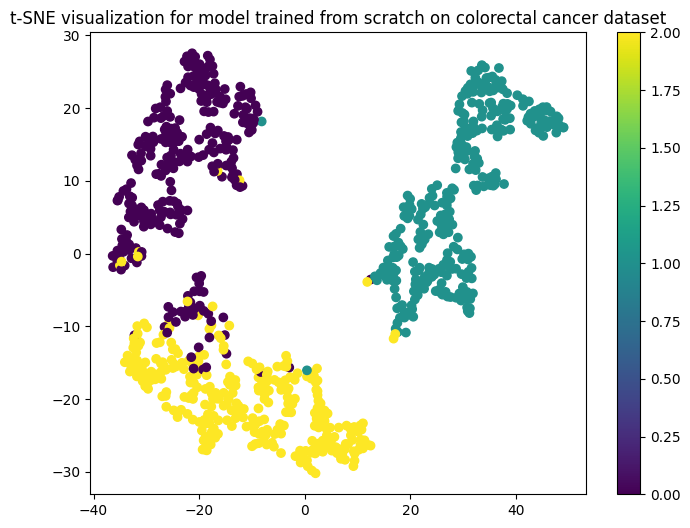

In [ ]:
best_model_path = base_path + '/weights/' + 'Colorectal Cancercolorectral_model_weights.pth'
print(best_model_path)
colorectal_cancer_classifier= torch.load(best_model_path)
visualize_features(colorectal_cancer_classifier, test_dataloader,device,"t-SNE visualization for model trained from scratch on colorectal cancer dataset")




In [ ]:

def train(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()

    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []

    for epoch in range(num_epochs):
        print("Epoch: ", epoch + 1)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Create a progress bar for the training loop
        with tqdm(total=len(dataloader)) as pbar:
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                pbar.update(1)  # Update the progress bar

        epoch_train_loss = running_loss / len(dataloader)
        epoch_train_accuracy = 100 * correct_train / total_train

        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss}")
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {epoch_train_accuracy}%")

    return train_losses, train_accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    predictions = []
    labels = []

    with torch.no_grad():
        for inputs, ground_truth in test_loader:
            inputs, ground_truth = inputs.to(device), ground_truth.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, ground_truth)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += ground_truth.size(0)
            correct_test += (predicted == ground_truth).sum().item()
            predictions.extend(predicted.cpu().numpy())
            labels.extend(ground_truth.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    return predictions, labels, test_loss

## loading the Pre-trained Network

In [ ]:

model = models.resnet50(pretrained=True)

# Freeze all convolutional layers and print the layer names
for name, param in model.named_parameters():
    if param.requires_grad is False:
        print(f"Freezing: {name}")
fc_layer = model.fc
num_input_features = fc_layer.in_features
num_output_features = fc_layer.out_features
print(f"Number of input features: {num_input_features}")
print(f"Number of output features (number of classes): {num_output_features}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.7MB/s]


Number of input features: 2048
Number of output features (number of classes): 1000


## Fine-tuning for Colorectal Cancer Classification

create a new fully connected layer(classification layer) for the number of classes in your dataset

In [ ]:
num_classes = len(dataset.classes)
model.fc = nn.Linear(num_input_features, num_classes)
model.fc.require_grad = True

Define the loss function and optimizer, batch size and train loaders, and device


In [ ]:
dataset = datasets['Colorectal Cancer']

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

train

In [ ]:
train_losses, train_accuracy = train(model, train_loader, criterion, optimizer, device, num_epochs=10)

Epoch:  1


100%|██████████| 150/150 [01:35<00:00,  1.57it/s]


Epoch 1/10, Training Loss: 0.2500657013555368
Epoch 1/10, Training Accuracy: 91.85416666666667%
Epoch:  2


100%|██████████| 150/150 [01:02<00:00,  2.40it/s]


Epoch 2/10, Training Loss: 0.20970459009210268
Epoch 2/10, Training Accuracy: 93.22916666666667%
Epoch:  3


100%|██████████| 150/150 [01:02<00:00,  2.40it/s]


Epoch 3/10, Training Loss: 0.1846216205259164
Epoch 3/10, Training Accuracy: 93.91666666666667%
Epoch:  4


100%|██████████| 150/150 [01:01<00:00,  2.43it/s]


Epoch 4/10, Training Loss: 0.17670335367321968
Epoch 4/10, Training Accuracy: 93.85416666666667%
Epoch:  5


100%|██████████| 150/150 [01:02<00:00,  2.41it/s]


Epoch 5/10, Training Loss: 0.16873920189837616
Epoch 5/10, Training Accuracy: 94.27083333333333%
Epoch:  6


100%|██████████| 150/150 [01:01<00:00,  2.45it/s]


Epoch 6/10, Training Loss: 0.1547793875883023
Epoch 6/10, Training Accuracy: 94.58333333333333%
Epoch:  7


100%|██████████| 150/150 [01:01<00:00,  2.43it/s]


Epoch 7/10, Training Loss: 0.14816300379733244
Epoch 7/10, Training Accuracy: 94.8125%
Epoch:  8


100%|██████████| 150/150 [01:01<00:00,  2.44it/s]


Epoch 8/10, Training Loss: 0.14463154884676138
Epoch 8/10, Training Accuracy: 95.0625%
Epoch:  9


100%|██████████| 150/150 [01:01<00:00,  2.45it/s]


Epoch 9/10, Training Loss: 0.14055323521296184
Epoch 9/10, Training Accuracy: 95.22916666666667%
Epoch:  10


100%|██████████| 150/150 [01:01<00:00,  2.45it/s]

Epoch 10/10, Training Loss: 0.13933012172579765
Epoch 10/10, Training Accuracy: 95.125%


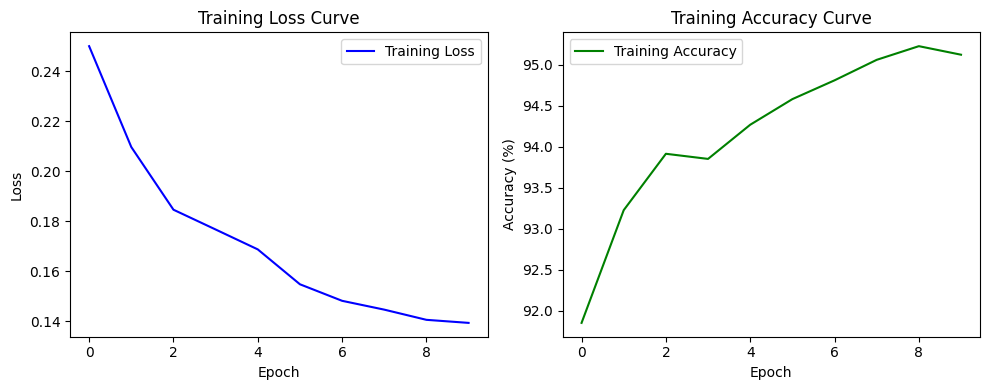

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy Curve')

plt.tight_layout()
plt.show()


In [ ]:
dataset1_pretrained_model_file_name = base_path + 'dataset1_model_using_pretrained_resnet50.pkl'
model_colorectal_pretrained = model
with open(dataset1_pretrained_model_file_name, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
dataset1_pretrained_model_file_name = base_path + 'dataset1_model_using_pretrained_resnet50.pkl'

with open(dataset1_pretrained_model_file_name, 'rb') as file:
    model = pickle.load(file)


## Results for Task 1 - part b

### Evaluation

Test Accuracy: 97.58%
Test Loss: 0.1014
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Loss: 0.10
Classification Report:
              precision    recall  f1-score   support

         MUS       0.96      0.98      0.97       385
        NORM       0.99      0.99      0.99       410
         STR       0.97      0.96      0.97       405

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Confusion Matrix:
[[377   2   6]
 [  1 405   4]
 [ 15   1 389]]


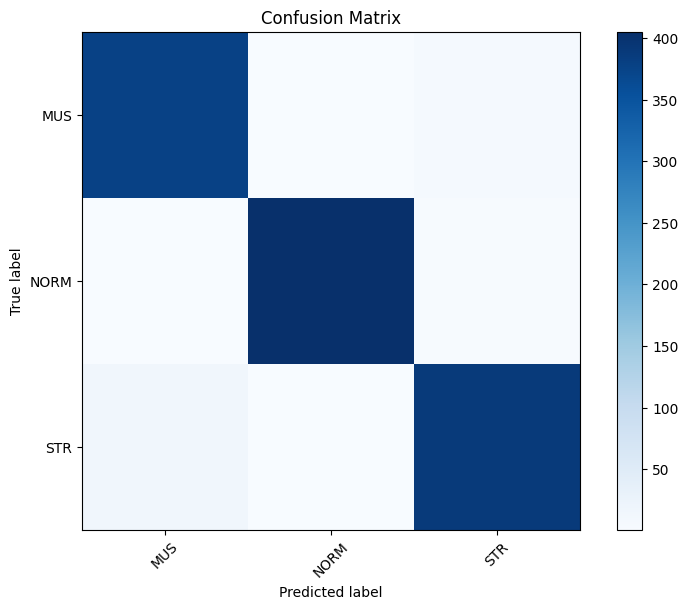

In [ ]:

# Testing loop
model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
predictions = []
labels = []

with torch.no_grad():
    for inputs, ground_truth in test_loader:
        inputs, ground_truth = inputs.to(device), ground_truth.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, ground_truth)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += ground_truth.size(0)
        correct_test += (predicted == ground_truth).sum().item()
        predictions.extend(predicted.cpu().numpy())
        labels.extend(ground_truth.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

class_names = dataset.classes

evaluate_classification_metrics(predictions, labels, test_loss,class_names)

In [ ]:
#todo : learning curve?

### T-SNE Visualization

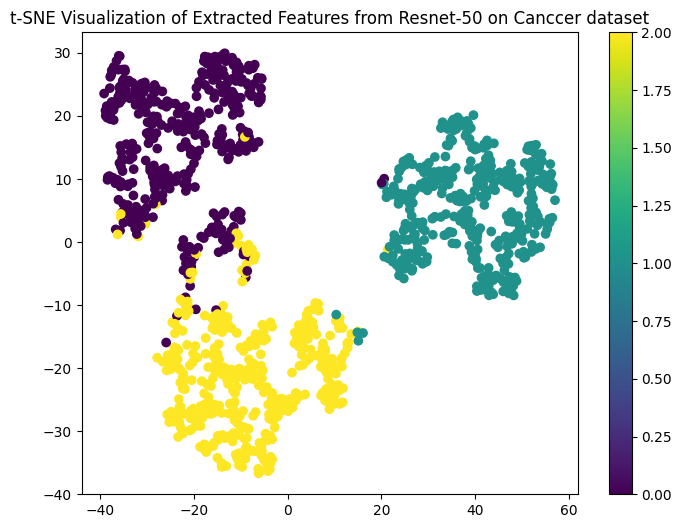

In [ ]:
visualize_features(model, test_loader, device,title = 't-SNE Visualization of Extracted Features from Resnet-50 on Canccer dataset')


# **Task 2**

## using the CNN encoder trained in task 1

### extracting features


In [9]:
best_model_path = base_path + '/weights/' + 'Colorectal Cancercolorectral_model_weights.pth'
print(best_model_path)
colorectal_cancer_classifier= torch.load(best_model_path)
feature_extractor = nn.Sequential(*list(colorectal_cancer_classifier.children())[:-2]).to(device)

d2_batch_size = 32
d3_batch_size = 32

prostate_data_loader = DataLoader(datasets['Prostate Cancer'], batch_size=d2_batch_size, shuffle=True)
animal_faces_data_loader = DataLoader(datasets['Animal Faces'], batch_size=d3_batch_size, shuffle=True)

prostate_pbar = tqdm(total=len(prostate_data_loader), desc="Prostate Features")
animal_faces_pbar = tqdm(total=len(animal_faces_data_loader), desc="Animal Faces Features")

# Create datasets for feature vectors and targets
prostate_data = []
animal_faces_data = []

for data_loader, pbar, feature_dataset in [(prostate_data_loader, prostate_pbar, prostate_data), (animal_faces_data_loader, animal_faces_pbar, animal_faces_data)]:
    feature_extractor.eval()  # Set the feature extractor to evaluation mode
    with torch.no_grad():
        for images, targets in data_loader:
            # Move images to the GPU
            images = images.to(device)
            # Apply ImageNet normalization to the images before feature extraction
            # images = normalize_transform(images)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1).cpu().numpy()
            feature_targets = list(zip(features, targets))
            feature_dataset.extend(feature_targets)
            pbar.update(1)  # Update the progress bar
prostate_pbar.close()
animal_faces_pbar.close()


/content/drive/My Drive/Comp6321 project dataset//weights/Colorectal Cancercolorectral_model_weights.pth


Animal Faces Features: 100%|██████████| 188/188 [1:08:15<00:00, 21.78s/it]


In [10]:


shared_folder_path = base_path

# Save the custom datasets (features and targets) using pickle
prostate_data_file = os.path.join(shared_folder_path, 'prostate_task1_features_data.pkl')
with open(prostate_data_file, 'wb') as file:
    pickle.dump(prostate_data, file)

animal_faces_data_file = os.path.join(shared_folder_path, 'animal_faces_task1_features_data.pkl')
with open(animal_faces_data_file, 'wb') as file:
    pickle.dump(animal_faces_data, file)


In [7]:
shared_folder_path = base_path
prostate_data_file = os.path.join(shared_folder_path, 'prostate_task1_features_data.pkl')

animal_faces_data_file = os.path.join(shared_folder_path, 'animal_faces_task1_features_data.pkl')

with open(prostate_data_file, 'rb') as file:
    prostate_data = pickle.load(file)

with open(animal_faces_data_file, 'rb') as file:
    animal_faces_data = pickle.load(file)


###  t-SNE visualization

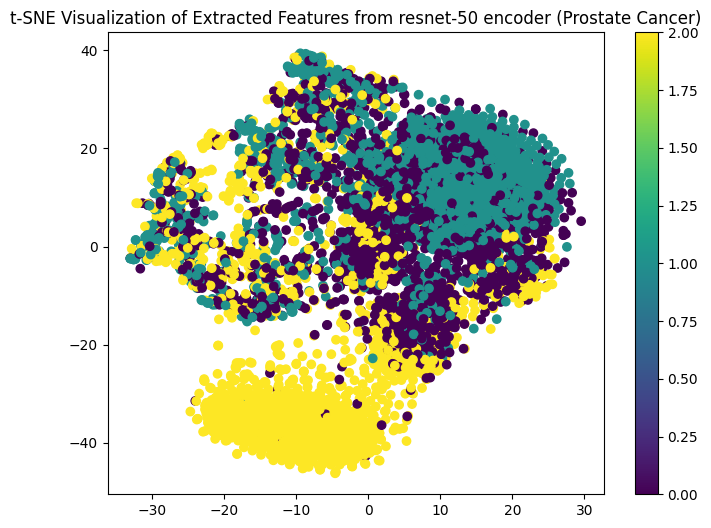

In [8]:
prostate_features, prostate_labels = zip(*prostate_data)
prostate_labels = [label.numpy() for label in prostate_labels]

# prostate_dataset = TensorDataset(torch.Tensor(prostate_features), torch.LongTensor(prostate_labels))
# prostate_data_loader = DataLoader(dataset=prostate_dataset, batch_size=batch_size, shuffle=True)

prostate_features = np.vstack(prostate_features)
# visualize_features(pretrained_model, prostate_data_loader, device = 'cpu')
tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(prostate_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=prostate_labels, cmap='viridis')
plt.title('t-SNE Visualization of Extracted Features from resnet-50 encoder (Prostate Cancer)')
plt.colorbar()
plt.show()


## using pre-trained ResNet-50

### extracting features  

note: we run the following cell once and store the features in drive, and after that we can load them from the drive.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_model = models.resnet50(pretrained=True).to(device)
# Remove the last classification layer ('fc') and the global average pooling layer ('avgpool')
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-2]).to(device)

# Define data transformations for normalization to ImageNet
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

d2_batch_size = 32
d3_batch_size = 32

prostate_data_loader = DataLoader(datasets['Prostate Cancer'], batch_size=d2_batch_size, shuffle=True)
animal_faces_data_loader = DataLoader(datasets['Animal Faces'], batch_size=d3_batch_size, shuffle=True)

prostate_pbar = tqdm(total=len(prostate_data_loader), desc="Prostate Features")
animal_faces_pbar = tqdm(total=len(animal_faces_data_loader), desc="Animal Faces Features")

# Create datasets for feature vectors and targets
prostate_data = []
animal_faces_data = []

for data_loader, pbar, feature_dataset in [(prostate_data_loader, prostate_pbar, prostate_data), (animal_faces_data_loader, animal_faces_pbar, animal_faces_data)]:
    feature_extractor.eval()  # Set the feature extractor to evaluation mode
    with torch.no_grad():
        for images, targets in data_loader:
            # Move images to the GPU
            images = images.to(device)
            # Apply ImageNet normalization to the images before feature extraction
            images = normalize_transform(images)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1).cpu().numpy()
            feature_targets = list(zip(features, targets))
            feature_dataset.extend(feature_targets)
            pbar.update(1)  # Update the progress bar
prostate_pbar.close()
animal_faces_pbar.close()


Animal Faces Features: 100%|██████████| 188/188 [1:05:16<00:00, 20.83s/it]


In [ ]:


shared_folder_path = base_path

# Save the custom datasets (features and targets) using pickle
prostate_data_file = os.path.join(shared_folder_path, 'prostate_resnet_features_data.pkl')
with open(prostate_data_file, 'wb') as file:
    pickle.dump(prostate_data, file)

animal_faces_data_file = os.path.join(shared_folder_path, 'animal_faces_resnet_features_data.pkl')
with open(animal_faces_data_file, 'wb') as file:
    pickle.dump(animal_faces_data, file)


In [ ]:
shared_folder_path = base_path
prostate_data_file = os.path.join(shared_folder_path, 'prostate_resnet_features_data.pkl')

animal_faces_data_file = os.path.join(shared_folder_path, 'animal_faces_resnet_features_data.pkl')

with open(prostate_data_file, 'rb') as file:
    prostate_data = pickle.load(file)

with open(animal_faces_data_file, 'rb') as file:
    animal_faces_data = pickle.load(file)


###  t-SNE visualization

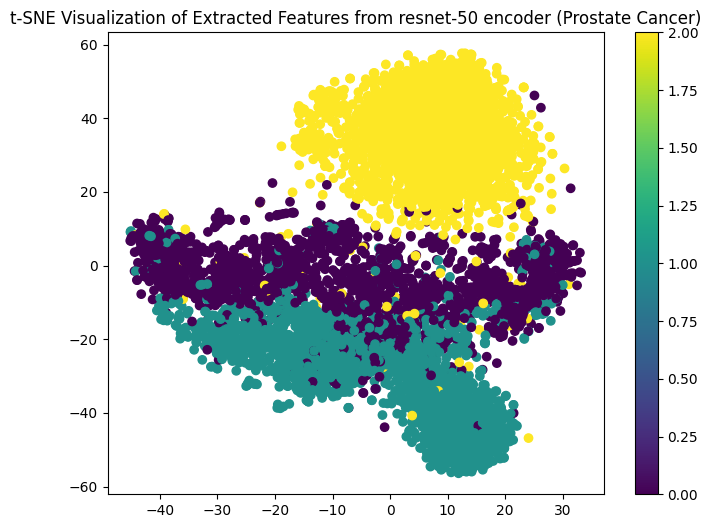

In [ ]:
prostate_features, prostate_labels = zip(*prostate_data)

prostate_labels = [label.numpy() for label in prostate_labels]

# prostate_dataset = TensorDataset(torch.Tensor(prostate_features), torch.LongTensor(prostate_labels))
# prostate_data_loader = DataLoader(dataset=prostate_dataset, batch_size=batch_size, shuffle=True)

prostate_features = np.vstack(prostate_features)
# visualize_features(pretrained_model, prostate_data_loader, device = 'cpu')
tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(prostate_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=prostate_labels, cmap='viridis')
plt.title('t-SNE Visualization of Extracted Features from resnet-50 encoder (Prostate Cancer)')
plt.colorbar()
plt.show()


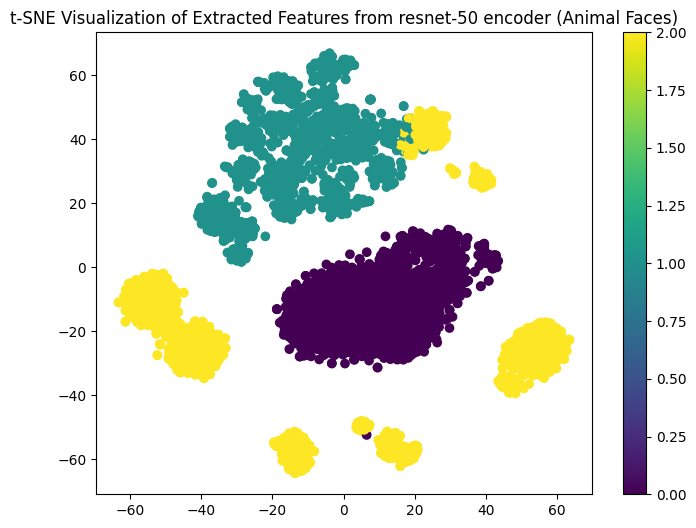

In [ ]:
animal_features, animal_labels = zip(*animal_faces_data)

animal_labels = [label.numpy() for label in animal_labels]

animal_features = np.vstack(animal_features)

tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(animal_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=animal_labels, cmap='viridis')
plt.title('t-SNE Visualization of Extracted Features from resnet-50 encoder (Animal Faces)')
plt.colorbar()
plt.show()


###  training ML models to classify the extracted features

#### k-nearest neighbors

Prostate cancer:

In [ ]:
prostate_features, prostate_labels = zip(*prostate_data) # we only use features for the clustering, we use labels for evaluation

n_neighbors = len(np.unique(prostate_labels))

print(n_neighbors)
X_train, X_test, y_train, y_test = train_test_split(prostate_features, prostate_labels, test_size=0.2, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, knn_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


3
Accuracy: 66.00%


animal face:


In [ ]:
n_neighbors = len(np.unique(animal_labels))

X_train, X_test, y_train, y_test = train_test_split(animal_features, animal_labels, test_size=0.2, random_state=42)
number_of_classes = len(np.unique(y_test))
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, knn_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.17%


#### Random Forrest

prostate cancer:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
n_neighbors = len(np.unique(prostate_labels))
X_train, X_test, y_train, y_test = train_test_split(prostate_features, prostate_labels, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 94.25%


animal face:


In [ ]:
n_neighbors = len(np.unique(animal_labels))
X_train, X_test, y_train, y_test = train_test_split(animal_features, animal_labels, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.17%
